In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pickle

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 1. Data

In [5]:
root_dir = "./data/MNIST/"
train_dataset = MNIST(root=root_dir, train=True, download=True, transform=ToTensor())
test_dataset = MNIST(root=root_dir, train=False, download=True, transform=ToTensor())

In [6]:
train_dataset.data.shape, test_dataset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [7]:
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
for img_tensor, labels in train_loader:
    print(f"{img_tensor.shape}, {labels.shape}")
    break

torch.Size([128, 1, 28, 28]), torch.Size([128])


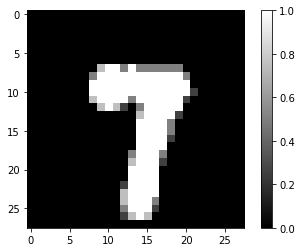

In [9]:
plt.imshow(img_tensor[0, 0], cmap="gray")
plt.colorbar()

# 2. Model and Training

In [100]:
# best lr
from models.MADE import MADE
from helpers.datasets import MNISTForMADE
from helpers.train_eval import lr_search

In [101]:
class WrapperMADE(MADE):
    def __init__(self, **kwargs):
        super(WrapperMADE, self).__init__(**kwargs)
    
    def forward(self, x):
        batch_size = x.shape[0]
        flattened = super().forward(x)
        return flattened.reshape(batch_size, -1, *self.orginal_shape).contiguous()

In [102]:
mnist_for_made = MNISTForMADE(train_dataset.data)
lr_train_loader = DataLoader(mnist_for_made, batch_size=BATCH_SIZE, shuffle=True)

In [103]:
made_params = dict(in_shape=(1, 28, 28), out_num_comp=2, hidden_sizes=[512, 512, 256])
wrapper_made = WrapperMADE(**made_params).to(DEVICE)
optimizer = torch.optim.Adam(wrapper_made.parameters(), lr=1e-6)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.76E-03


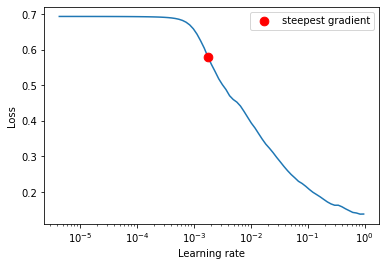

In [104]:
lr_history = lr_search(wrapper_made, nn.CrossEntropyLoss(), optimizer, lr_train_loader, 
                       end_lr=2, device=torch.device("cuda"))

In [105]:
lr = 1.76e-3

In [106]:
from helpers.train_eval import MADETrainer

In [107]:
made_params["in_shape"] = (28, 28)
made = MADE(**made_params).to(DEVICE)
optimizer = torch.optim.Adam(made.parameters(), lr=lr)
made_trainer = MADETrainer(made, train_loader, test_loader, optimizer)

epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

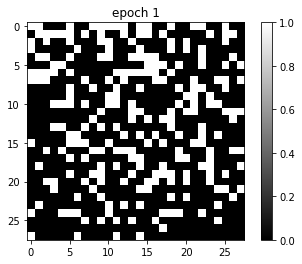

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

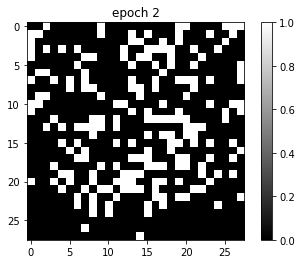

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

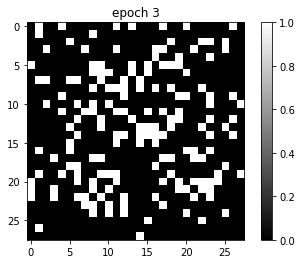

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

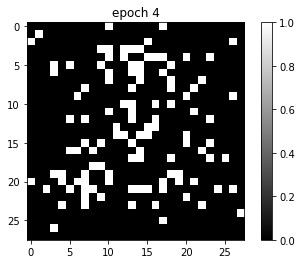

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

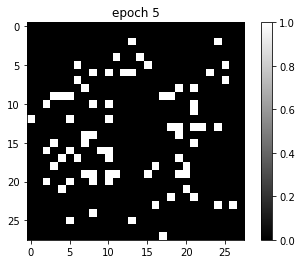

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

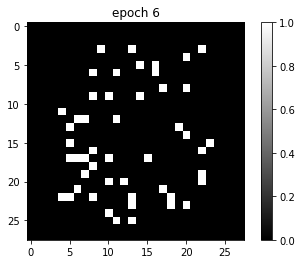

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

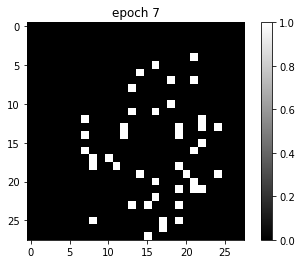

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

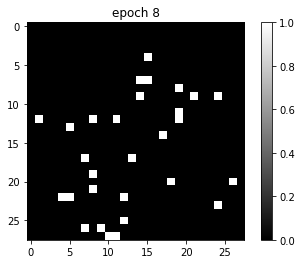

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

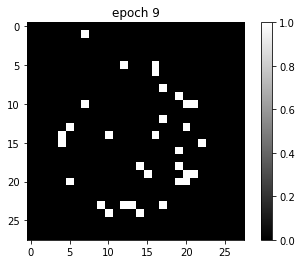

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

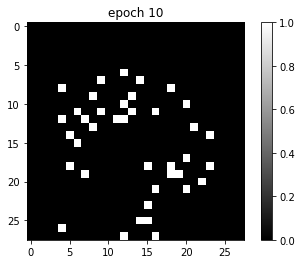

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

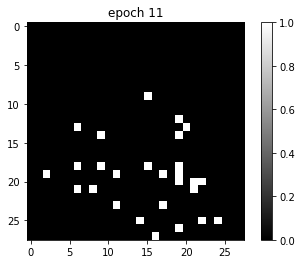

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

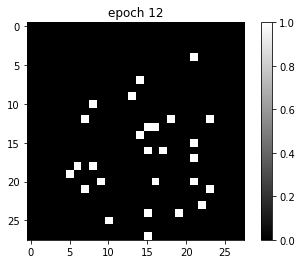

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

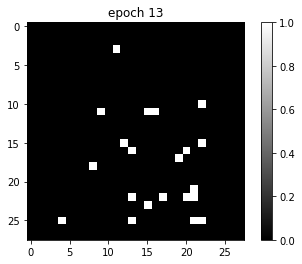

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

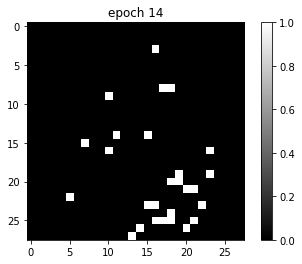

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

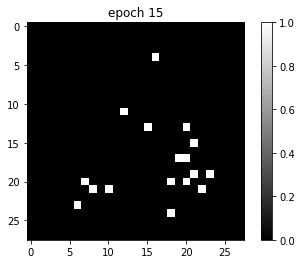

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

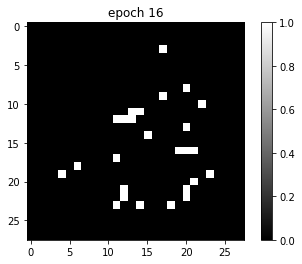

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

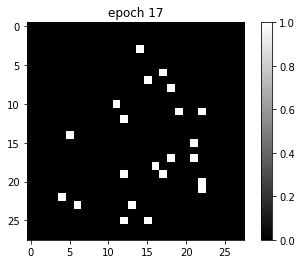

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

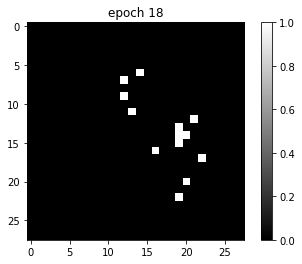

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

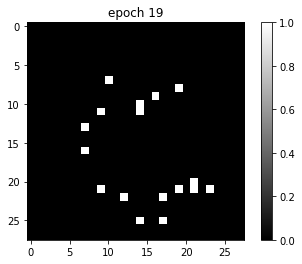

batch training:   0%|          | 0/469 [00:00<?, ?it/s]

batch eval:   0%|          | 0/79 [00:00<?, ?it/s]

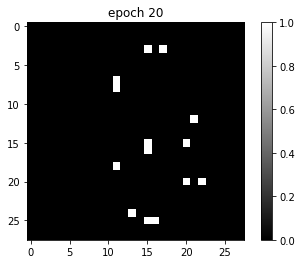

In [108]:
train_losses, eval_losses = made_trainer.train(if_plot=True)

# 3. Evaluation and Sampling

In [109]:
tr_history_path = "./params/made_mnist/1636329416_3990479//training.pkl"
model_path = "./params/made_mnist/1636329416_3990479/epoch_19_eval_loss_0_0295.pt"

In [111]:
# with open(tr_history_path, "wb") as wf:
#     pickle.dump([train_losses, eval_losses], wf)

In [112]:
made_params = dict(in_shape=(28, 28), out_num_comp=2, hidden_sizes=[512, 512, 256])
made_reload = MADE(**made_params).to(DEVICE)

In [113]:
made_reload.load_state_dict(torch.load(model_path))
made_reload.eval()
print(end="")

In [114]:
with open(tr_history_path, "rb") as rf:
    train_losses, eval_losses = pickle.load(rf)

In [115]:
from helpers.utils import plot_training_history, MADE_sample_plot

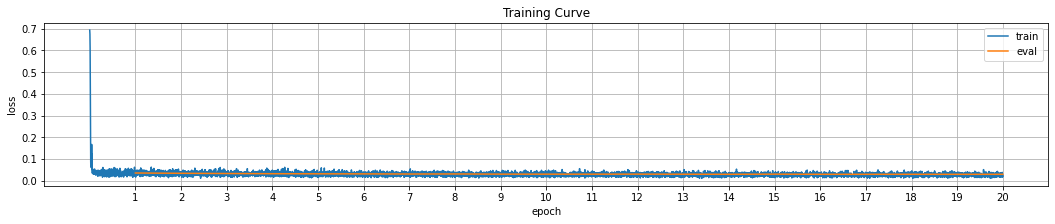

In [116]:
plot_training_history(train_losses, eval_losses, figsize=(18, 3))

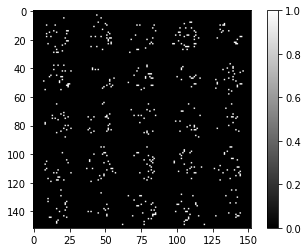

In [117]:
MADE_sample_plot(made_reload)